# Deep Learning Term Project for ECG (DIL700)

# Iteration 4

## Imports

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib widget
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import class_weight
import warnings
import os
from general_functions import *
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy


warnings.filterwarnings('ignore')

## Loading Dataset

Collect all the data from the csv files

In [4]:
train_df=combine_csv_files_to_df('./Dataset_mitbih/Training/')
test_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# Put together the training and testing
full_df=pd.concat([train_df,test_df],ignore_index=True)


## Converting dataset into Normal/abnormal instead of 5 classes

In [5]:
train_df.loc[train_df[187] == 3, 187] = 1
test_df.loc[test_df[187] == 3, 187] = 1
full_df.loc[full_df[187] == 3, 187] = 1

train_df.loc[train_df[187] == 2, 187] = 1
test_df.loc[test_df[187] == 2, 187] = 1
full_df.loc[full_df[187] == 2, 187] = 1

train_df.loc[train_df[187] == 4, 187] = 1
test_df.loc[test_df[187] == 4, 187] = 1
full_df.loc[full_df[187] == 4, 187] = 1

In [6]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
87551,0.906122,0.624490,0.595918,0.575510,0.530612,0.481633,0.444898,0.387755,0.322449,0.191837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
87552,0.858228,0.645570,0.845570,0.248101,0.167089,0.131646,0.121519,0.121519,0.118987,0.103797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
test_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
print(train_df[187].unique())

[0. 1.]


In [9]:
labels = ['Normal', 'Abnormal']
labels_short =  ["N","A"]

In [10]:
print('Number of samples in data:')
print(labels[0],':', len(train_df[train_df[187]==0]))
print(labels[1],':', len(train_df[train_df[187]==1]))
# print(labels[2],':', len(train_df[train_df[187]==2]))
# print(labels[3],':', len(train_df[train_df[187]==3]))
# print(labels[4],':', len(train_df[train_df[187]==4]))

Number of samples in data:
Normal : 72471
Abnormal : 15083


In [11]:
print('Number of samples in data:')
print(labels[0],':', len(test_df[test_df[187]==0]))
print(labels[1],':', len(test_df[test_df[187]==1]))
# print(labels[2],':', len(test_df[test_df[187]==2]))
# print(labels[3],':', len(test_df[test_df[187]==3]))
# print(labels[4],':', len(test_df[test_df[187]==4]))

Number of samples in data:
Normal : 18118
Abnormal : 3774


## Preparation

In [13]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=82)

X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1]

In [14]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
64726,1.000000,0.796117,0.337379,0.101942,0.118932,0.118932,0.070388,0.063107,0.070388,0.067961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22763,0.987433,0.903052,0.495512,0.143627,0.161580,0.202873,0.177738,0.175943,0.177738,0.168761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73919,1.000000,0.883721,0.213953,0.000000,0.079070,0.134884,0.106977,0.148837,0.227907,0.186047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51329,0.971717,0.709091,0.117172,0.008081,0.109091,0.086869,0.092929,0.072727,0.074747,0.062626,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
65634,1.000000,0.755747,0.528736,0.336207,0.181034,0.086207,0.040230,0.017241,0.014368,0.011494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38510,0.975357,0.941634,0.498054,0.000000,0.068742,0.125811,0.057069,0.050584,0.044099,0.040208,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19805,0.990672,0.777985,0.139925,0.037313,0.098881,0.102612,0.115672,0.111940,0.110075,0.123134,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41091,1.000000,0.905405,0.705405,0.354054,0.170270,0.124324,0.102703,0.059459,0.062162,0.037838,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4546,1.000000,0.510791,0.000000,0.089928,0.089928,0.118705,0.111511,0.115108,0.097122,0.107914,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
y_train

64726    0.0
22763    0.0
73919    1.0
51329    0.0
65634    0.0
        ... 
38510    0.0
19805    0.0
41091    0.0
4546     0.0
77955    1.0
Name: 187, Length: 70043, dtype: float64

In [16]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
30886,0.865258,0.655218,0.260238,0.030383,0.000000,0.079260,0.126816,0.120211,0.107001,0.105680,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
72653,0.931579,0.836842,0.121053,0.028947,0.197368,0.218421,0.171053,0.189474,0.205263,0.197368,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
37071,0.917241,0.562069,0.106897,0.117241,0.151724,0.120690,0.096552,0.089655,0.079310,0.075862,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
42520,1.000000,0.862797,0.546174,0.081794,0.092348,0.197889,0.327177,0.343008,0.374670,0.369393,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
72974,1.000000,0.940711,0.288538,0.000000,0.047431,0.122530,0.102767,0.122530,0.225296,0.237154,...,0.371542,0.363636,0.359684,0.367589,0.367589,0.359684,0.363636,0.351779,0.379447,0.375494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58341,1.000000,0.935412,0.492205,0.144766,0.216036,0.202673,0.200445,0.189310,0.182628,0.171492,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
54057,0.896382,0.722039,0.440789,0.203947,0.024671,0.000000,0.032895,0.055921,0.069079,0.062500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18964,0.971875,0.925000,0.634375,0.362500,0.075000,0.065625,0.109375,0.103125,0.187500,0.212500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
26375,0.974227,0.819588,0.628866,0.422680,0.237113,0.128866,0.108247,0.154639,0.149485,0.139175,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Dataset Distribution

### Training set

In [17]:
train_df[187]=train_df[187].astype(int)
equilibre_train=train_df[187].value_counts(sort=False)
print(equilibre_train)

0    72471
1    15083
Name: 187, dtype: int64


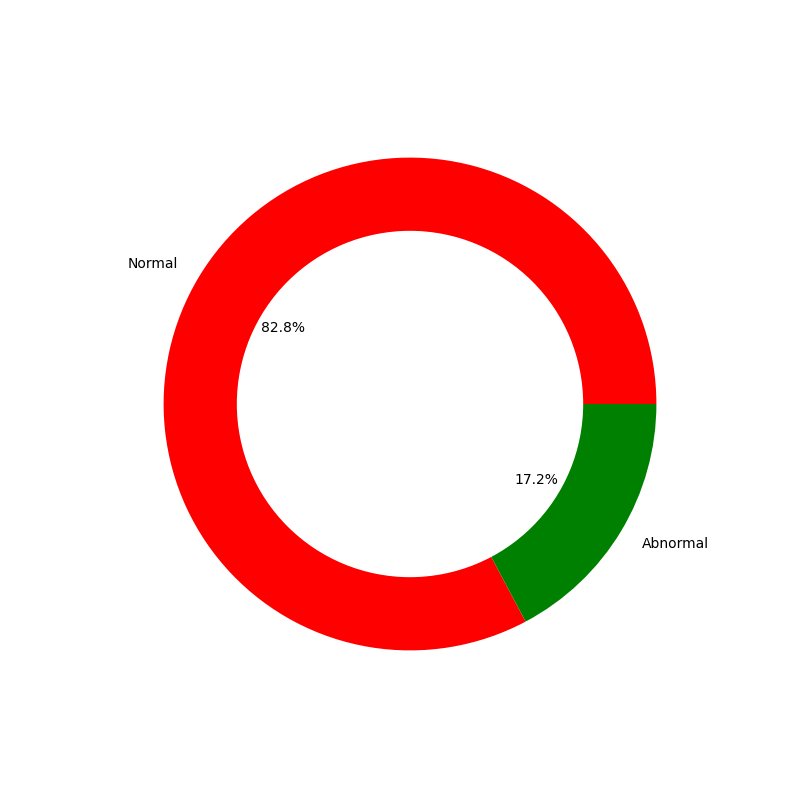

In [18]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_train, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Testing set

In [19]:
test_df[187]=test_df[187].astype(int)
equilibre_test=test_df[187].value_counts(sort=False)
print(equilibre_test)

0    18118
1     3774
Name: 187, dtype: int64


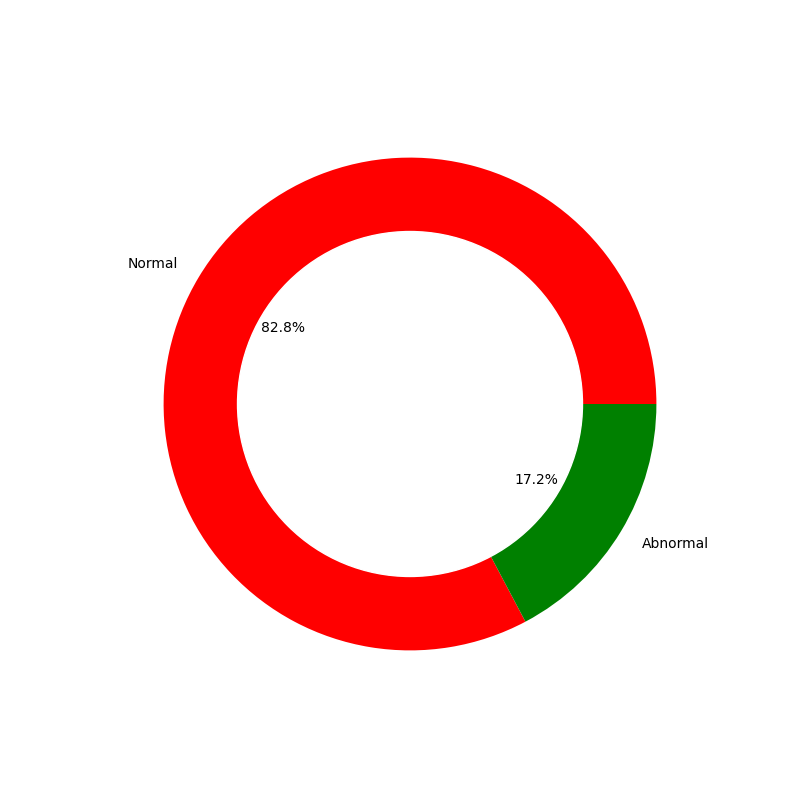

In [20]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre_test, labels= labels
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

# Simple ANN

In [21]:
model_ann = Sequential([
    Dense(256, activation='relu', input_dim=(X_train.shape[1])),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


model_ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_ann_5.h5', monitor='val_loss', save_best_only=True)]


history_ann = model_ann.fit(X_train, y_train, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid))
model_ann.load_weights('best_ann_5.h5')
#save_model(model_ann, 'Simple_ANN_MITBIH', 'keras')

Epoch 1/40
2189/2189 [==============================] - 9s 4ms/step - loss: 0.1722 - accuracy: 0.9435 - val_loss: 0.1232 - val_accuracy: 0.9593
Epoch 2/40
2189/2189 [==============================] - 6s 3ms/step - loss: 0.1129 - accuracy: 0.9643 - val_loss: 0.0945 - val_accuracy: 0.9698
Epoch 3/40
2189/2189 [==============================] - 7s 3ms/step - loss: 0.0951 - accuracy: 0.9694 - val_loss: 0.0849 - val_accuracy: 0.9722
Epoch 4/40
2189/2189 [==============================] - 8s 4ms/step - loss: 0.0833 - accuracy: 0.9741 - val_loss: 0.0904 - val_accuracy: 0.9717
Epoch 5/40
2189/2189 [==============================] - 8s 3ms/step - loss: 0.0757 - accuracy: 0.9757 - val_loss: 0.0820 - val_accuracy: 0.9735
Epoch 6/40
2189/2189 [==============================] - 7s 3ms/step - loss: 0.0705 - accuracy: 0.9772 - val_loss: 0.0841 - val_accuracy: 0.9733
Epoch 7/40
2189/2189 [==============================] - 7s 3ms/step - loss: 0.0655 - accuracy: 0.9788 - val_loss: 0.0680 - val_accuracy:

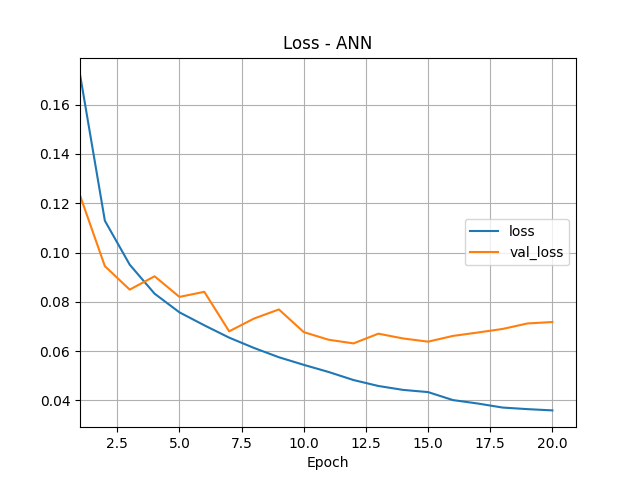

In [23]:
history_df_ann = pd.DataFrame(history_ann.history)
history_df_ann.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - ANN")
plt.legend(cols, loc="right")
plt.show()

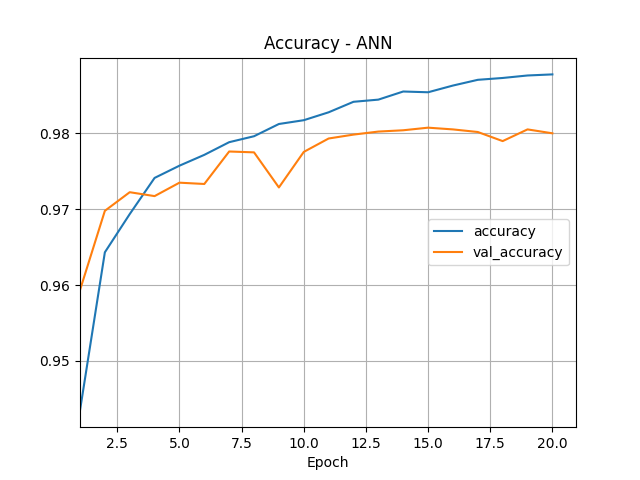

In [24]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_ann[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - ANN")
plt.legend(cols, loc="right")
plt.show()

In [28]:
# Predict test set labels
y_pred_1  = model_ann.predict(X_test)
y_pred_ann = np.where(y_pred_1 > 0.5, 1, 0)

print('Accuracy of ANN: ', accuracy_score(y_test, y_pred_ann))

685/685 [==============================] - 1s 1ms/step
Accuracy of ANN:  0.9786680065777453


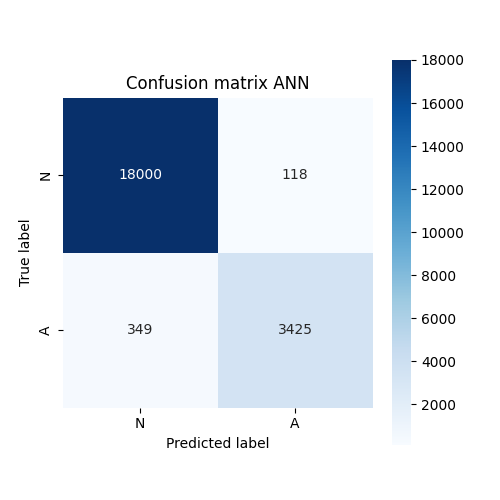

In [29]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_ann)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix ANN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [30]:
print(classification_report(y_test, y_pred_ann, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9810    0.9935    0.9872     18118
    Abnormal     0.9667    0.9075    0.9362      3774

    accuracy                         0.9787     21892
   macro avg     0.9738    0.9505    0.9617     21892
weighted avg     0.9785    0.9787    0.9784     21892



### CNN

In [31]:
model_cnn = Sequential([
    Conv1D(64, kernel_size=6, activation='relu', input_shape=(X_train.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=3, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_cnn_5.h5', monitor='val_loss', save_best_only=True)]


history_cnn = model_cnn.fit(X_train, y_train, epochs=40, callbacks=callbacks, batch_size=32, validation_data=(X_valid, y_valid))

model_cnn.load_weights('best_cnn_5.h5')
#save_model(model_cnn, 'Simple_CNN_MITBIH', 'keras')

Epoch 1/40
2189/2189 [==============================] - 17s 7ms/step - loss: 0.1084 - accuracy: 0.9641 - val_loss: 0.0733 - val_accuracy: 0.9755
Epoch 2/40
2189/2189 [==============================] - 16s 7ms/step - loss: 0.0643 - accuracy: 0.9793 - val_loss: 0.0632 - val_accuracy: 0.9789
Epoch 3/40
2189/2189 [==============================] - 16s 7ms/step - loss: 0.0505 - accuracy: 0.9837 - val_loss: 0.0566 - val_accuracy: 0.9812
Epoch 4/40
2189/2189 [==============================] - 14s 6ms/step - loss: 0.0414 - accuracy: 0.9863 - val_loss: 0.0721 - val_accuracy: 0.9772
Epoch 5/40
2189/2189 [==============================] - 14s 6ms/step - loss: 0.0361 - accuracy: 0.9884 - val_loss: 0.0549 - val_accuracy: 0.9827
Epoch 6/40
2189/2189 [==============================] - 14s 6ms/step - loss: 0.0305 - accuracy: 0.9898 - val_loss: 0.0535 - val_accuracy: 0.9808
Epoch 7/40
2189/2189 [==============================] - 15s 7ms/step - loss: 0.0270 - accuracy: 0.9909 - val_loss: 0.0490 - val_ac

In [ ]:
history_df_cnn = pd.DataFrame(history_cnn.history)
history_df_cnn.index += 1

cols = ['loss', 'val_loss']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Loss - CNN")
plt.legend(cols, loc="right")
plt.show()

In [ ]:
cols = ['accuracy', 'val_accuracy']

plt.figure()
plt.plot(history_df_cnn[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt.title("Accuracy - CNN")
plt.legend(cols, loc="right")
plt.show()

In [32]:
# Predict test set labels
y_pred_2  = model_cnn.predict(X_test)
y_pred_cnn = np.where(y_pred_2 > 0.5, 1, 0)

print('Accuracy of CNN: ', accuracy_score(y_test, y_pred_cnn))

685/685 [==============================] - 1s 2ms/step
Accuracy of CNN:  0.9871642609172301


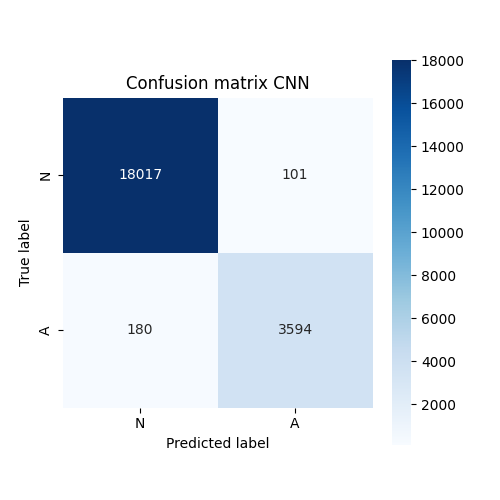

In [33]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Plot confusion matrix
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix CNN')
ax.xaxis.set_ticklabels(labels_short)
ax.yaxis.set_ticklabels(labels_short)
plt.show()

In [34]:
print(classification_report(y_test, y_pred_cnn, target_names=labels, digits=4))

              precision    recall  f1-score   support

      Normal     0.9901    0.9944    0.9923     18118
    Abnormal     0.9727    0.9523    0.9624      3774

    accuracy                         0.9872     21892
   macro avg     0.9814    0.9734    0.9773     21892
weighted avg     0.9871    0.9872    0.9871     21892



# Test which classes are not classified as abnormal

In [ ]:
# Predict test set labels
y_pred_2  = model_cnn.predict(X_test)
y_pred_cnn = np.where(y_pred_2 > 0.5, 1, 0)

print('Accuracy of CNN: ', accuracy_score(y_test, y_pred_cnn))

685/685 [==============================] - 1s 2ms/step
Accuracy of CNN:  0.9871642609172301


In [47]:
check_df=combine_csv_files_to_df('./Dataset_mitbih/Testing/')
# copy the last column in a new dataframe
compare_df = pd.DataFrame()
compare_df['label'] = check_df.iloc[:, -1]

In [48]:
# Make a new df a past the last column of check_df together with the predicted labels
compare_df['Predicted'] = y_pred_cnn

In [52]:
# if last column is equal to 1 and the predicted label is higer than 1, then the compare label is the predicted label
# else the compare label is 0
compare_df['compare'] = np.where((compare_df['Predicted'] == 0) & (compare_df['label'] >= 1), compare_df['label'], 0)

In [53]:
compare_df['compare']=compare_df['compare'].astype(int)
equilibre=compare_df['compare'].value_counts(sort=False)
print(equilibre)

0    21712
1      108
2       37
3       22
4       13
Name: compare, dtype: int64


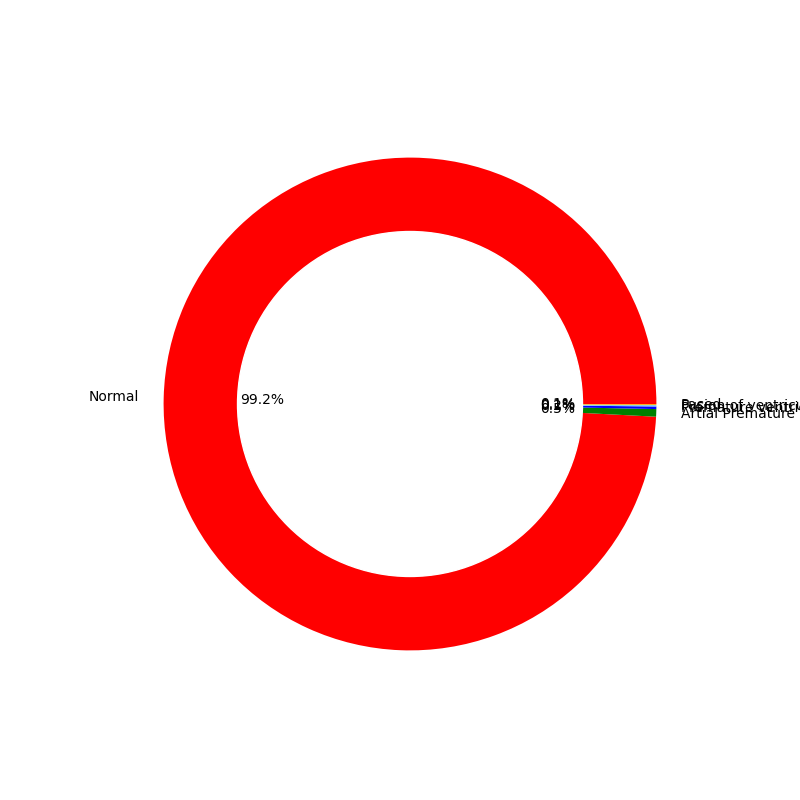

In [56]:
plt.figure(figsize=(8,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels= ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Fusion of ventricular and normal', 'Paced']
        , colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [57]:
model_cnn.load_weights('best_cnn_5.h5')
save_model(model_cnn, 'CNN_MITBIH_2_Classes', 'keras')